<a href="https://colab.research.google.com/github/antoineor/Super-resolution-healthcare/blob/main/Super_resolution_Unet3%2B_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Download latest version
path = kagglehub.dataset_download("hamdallak/the-iqothnccd-lung-cancer-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:02<00:00, 71.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/versions/1


# Data loading and preprocessing



*   Loading the data from kaggle - The IQ-OTH/NCCD lung cancer dataset
*   Regrouping the images from Normal cases, Malignant cases, Bengin cases
*   Ensuring that all the images are in (512,512)
*   Downsampling all the images in the (128,128) format



In [2]:
original_dir = '/root/.cache/kagglehub/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset/versions/1/The IQ-OTHNCCD lung cancer dataset'

In [3]:
for files in os.listdir(original_dir):
  print(files)

Normal cases
Malignant cases
Bengin cases
IQ-OTH_NCCD lung cancer dataset.txt


In [6]:

cases = ['/Bengin cases','/Normal cases','/Malignant cases']


output_size = (128, 128)
target_size = (512, 512)

original_images = []
downsampled_images = []
to_big = []

for case1 in cases:
  for img_path in glob(os.path.join(original_dir+case1, "*.jpg")):
      img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
      if img.shape == target_size:
        original_images.append(img)
        img_down = cv2.resize(img, output_size, interpolation=cv2.INTER_CUBIC)
        downsampled_images.append(img_down)
      else:
        if img.shape[0]>=512:
          to_big.append(img)



In [7]:
#Some of the images aren't in the (512, 512) format

for i in to_big:
  print(i.shape)

(512, 623)
(512, 623)
(512, 801)
(512, 801)
(512, 623)
(512, 623)
(512, 623)
(512, 801)
(512, 623)
(512, 801)
(512, 801)
(512, 801)
(512, 801)
(512, 801)
(512, 623)
(512, 623)
(512, 623)
(512, 801)
(512, 623)
(512, 801)
(512, 801)
(512, 623)
(512, 623)
(512, 801)
(512, 623)
(512, 623)
(512, 801)
(512, 623)
(512, 801)
(512, 623)
(512, 623)
(512, 801)
(512, 623)
(512, 801)
(512, 623)
(512, 801)
(512, 623)
(512, 801)
(512, 623)
(512, 623)
(512, 623)
(512, 801)
(512, 801)
(512, 801)
(512, 801)
(512, 801)
(512, 623)
(512, 801)
(512, 801)
(512, 623)
(512, 801)
(512, 801)
(512, 623)
(512, 801)
(512, 623)
(512, 623)
(512, 623)
(512, 623)
(512, 623)


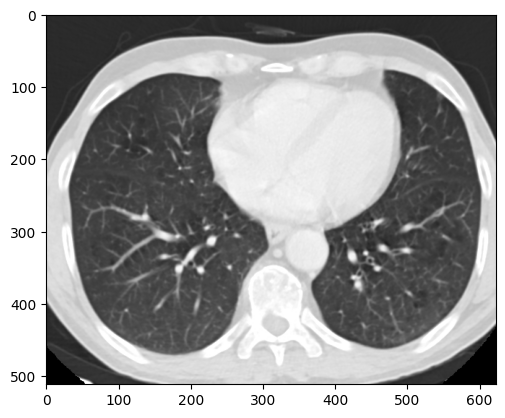

In [6]:
index =  np.random.randint(len(to_big))

plt.imshow(to_big[index], cmap='gray')

For the images that aren't in the (512, 512) format, we randomly crop the images in order to augment the number of images in the dataset

In [7]:
#Random crop of these too big images to augment dataset :

def random_crop(image, crop_size=(512, 512)):
    h, w = image.shape
    if w < crop_size[1]:
        raise ValueError(f"Image width ({w}) is smaller than crop width ({crop_size[1]})")

    x_start = np.random.randint(0, w - crop_size[1])
    cropped_image = image[:, x_start:x_start + crop_size[1]]
    return cropped_image

def generate_crops(image_list, num_crops=500):
    cropped_images = []
    for _ in range(num_crops):
        index = np.random.randint(len(image_list))
        img = image_list[index]
        cropped = random_crop(img)
        cropped_images.append(cropped)
    return np.array(cropped_images)

new_images = generate_crops(to_big)

In [8]:
new_images.shape

(500, 512, 512)

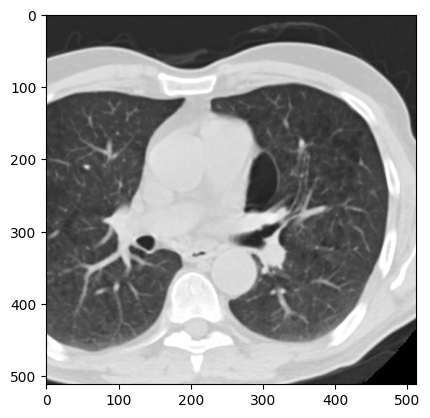

In [9]:
index =  np.random.randint(len(to_big))

plt.imshow(new_images[index], cmap='gray')

In [10]:
#add the new images in original and downsized

for i in range(new_images.shape[0]):
    img = new_images[i]
    if img.shape == target_size:
      original_images.append(img)
      img_down = cv2.resize(img, output_size, interpolation=cv2.INTER_CUBIC)
      downsampled_images.append(img_down)

In [11]:
original_images = np.array(original_images)
downsampled_images = np.array(downsampled_images)

In [12]:
original_images.shape

(1536, 512, 512)

In [13]:
#Ensuring the the GPU is used

import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU as the default device
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("GPU is now being used.")
    except RuntimeError as e:
        print(e)


GPU is now being used.


We will then proceed to a data augmentation on all the images, Rotating them, shifting them and adjusting brightness and flipping them. This will allow us to double the size of our dataset (from 1536 to 3072)

In [14]:
#Data augmentation on all the images

import tensorflow.keras.preprocessing.image as img_prep

def augment_images(original_images, downsampled_images):
    augmented_originals = []
    augmented_downsampled = []

    data_gen = img_prep.ImageDataGenerator(
        rotation_range=15,      # Rotate up to ±15 degrees
        width_shift_range=0.05, # Shift width by ±5%
        height_shift_range=0.05,# Shift height by ±5%
        horizontal_flip=True,   # Flip images horizontally
        brightness_range=[0.9, 1.1] # Adjust brightness
    )

    for i in range(len(original_images)):
        orig_img = np.expand_dims(original_images[i], axis=(0, -1))
        down_img = np.expand_dims(downsampled_images[i], axis=(0, -1))

        aug_iter = data_gen.flow(orig_img, batch_size=1, seed=42)
        aug_orig = next(aug_iter)[0]

        aug_iter_down = data_gen.flow(down_img, batch_size=1, seed=42)
        aug_down = next(aug_iter_down)[0]

        augmented_originals.append(aug_orig.squeeze())  # Remove batch & channel dimension
        augmented_downsampled.append(aug_down.squeeze())


    augmented_originals = np.array(augmented_originals)
    augmented_downsampled = np.array(augmented_downsampled)


    new_original_images = np.concatenate([original_images, augmented_originals], axis=0)
    new_downsampled_images = np.concatenate([downsampled_images, augmented_downsampled], axis=0)

    return new_original_images, new_downsampled_images


original_images_aug, downsampled_images_aug = augment_images(original_images, downsampled_images)

print("Original dataset size:", original_images.shape[0])
print("Augmented dataset size:", original_images_aug.shape[0])


Original dataset size: 1536
Augmented dataset size: 3072


In [15]:
original_images_aug[1].shape, downsampled_images_aug[1].shape

((512, 512), (128, 128))

(-0.5, 127.5, 127.5, -0.5)

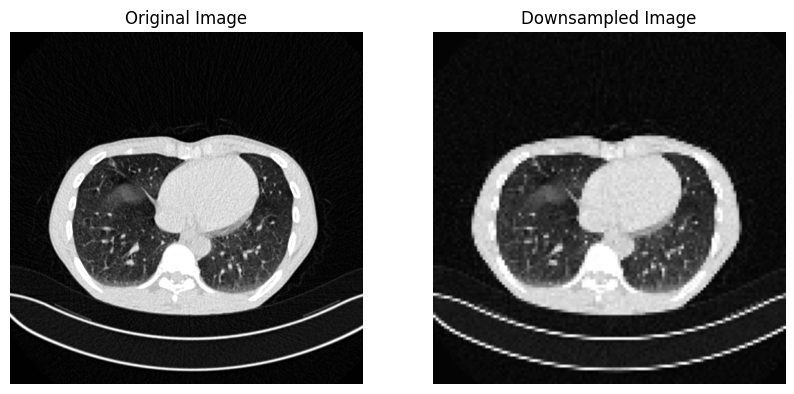

In [16]:

index = np.random.randint(original_images_aug.shape[0])


plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(original_images_aug[index], cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(downsampled_images_aug[index], cmap='gray')
plt.title("Downsampled Image")
plt.axis("off")

(-0.5, 511.5, 511.5, -0.5)

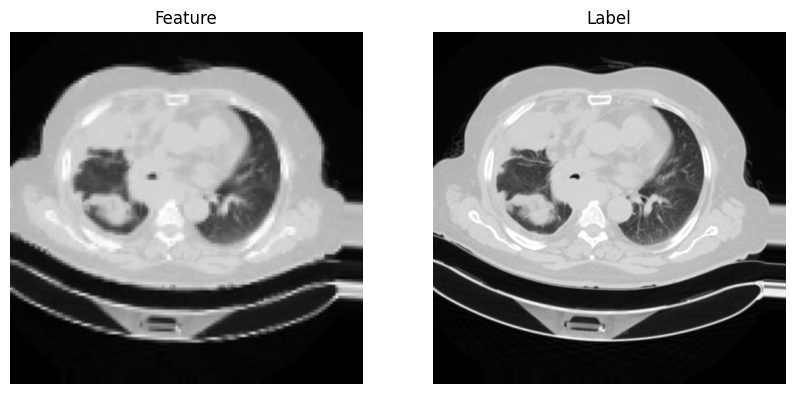

In [17]:
#Train_test_split
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(downsampled_images_aug,original_images_aug, test_size = 0.1, shuffle = True )


X_train = X_train/255.
X_test = X_test/255.
y_train = y_train/255.
y_test = y_test/255.


index = np.random.randint(X_test.shape[0])


plt.figure(figsize=(10, 5))
y_test = tf.expand_dims(y_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)

plt.subplot(1, 2, 1)
plt.imshow(X_test[index], cmap='gray')
plt.title("Feature")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(y_test[index], cmap='gray')
plt.title("Label")
plt.axis("off")

# The Model : Unet3+


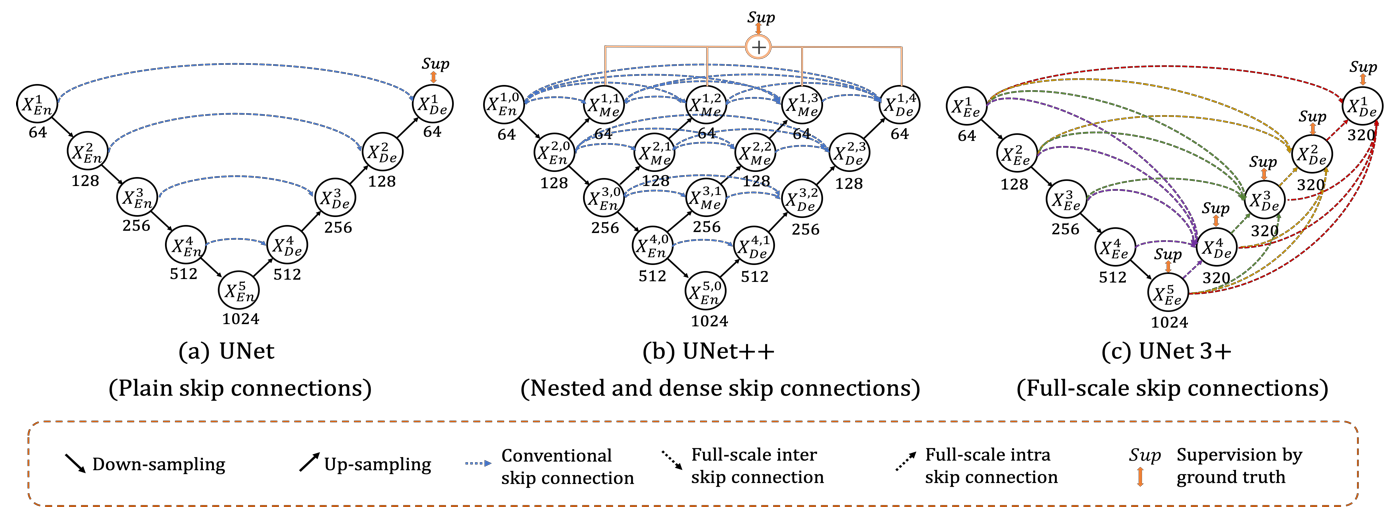


We adapted a version of the Unet3+ model taken from :
https://github.com/nikhilroxtomar/UNET-3-plus-Implementation-in-TensorFlow-and-PyTorch


We adapted this version to match the needs of the super resolution task:


*   One channel of output
*   ReLu Activation function for output
*   Input size of (128,128)
*   We add 2 upsampling Layers $(2,2)$ in order to increase the dimension of the output after the final decoder block $(d_1)$



In [18]:
import os

import tensorflow as tf
import tensorflow.keras.layers as L

def conv_block(x, num_filters, act=True):
    x = L.Conv2D(num_filters, kernel_size=3, padding="same")(x)

    if act == True:
        x = L.BatchNormalization()(x)
        x = L.Activation("relu")(x)

    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    x = conv_block(x, num_filters)

    p = L.MaxPool2D((2, 2))(x)
    return x, p

def unet3plus(input_shape):
    """ Inputs """
    inputs = L.Input(input_shape, name="input_layer")

    """ Encoder """
    e1, p1 = encoder_block(inputs, 64)
    e2, p2 = encoder_block(p1, 128)
    e3, p3 = encoder_block(p2, 256)
    e4, p4 = encoder_block(p3, 512)

    """ Bottleneck """
    e5 = conv_block(p4, 1024)
    e5 = conv_block(e5, 1024)

    """ Decoder 4 """
    e1_d4 = L.MaxPool2D((8, 8))(e1)
    e1_d4 = conv_block(e1_d4, 64)

    e2_d4 = L.MaxPool2D((4, 4))(e2)
    e2_d4 = conv_block(e2_d4, 64)

    e3_d4 = L.MaxPool2D((2, 2))(e3)
    e3_d4 = conv_block(e3_d4, 64)

    e4_d4 = conv_block(e4, 64)

    e5_d4 = L.UpSampling2D((2, 2), interpolation="bilinear")(e5)
    e5_d4 = conv_block(e5_d4, 64)

    d4 = L.Concatenate()([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4])
    d4 = conv_block(d4, 64*5)

    """ Decoder 3 """ #8000F8
    e1_d3 = L.MaxPool2D((4, 4))(e1)
    e1_d3 = conv_block(e1_d3, 64)

    e2_d3 = L.MaxPool2D((2, 2))(e2)
    e2_d3 = conv_block(e2_d3, 64)

    e3_d3 = conv_block(e3, 64)

    d4_d3 = L.UpSampling2D((2, 2), interpolation="bilinear")(d4)
    d4_d3 = conv_block(d4_d3, 64)

    e5_d3 = L.UpSampling2D((4, 4), interpolation="bilinear")(e5)
    e5_d3 = conv_block(e5_d3, 64)

    d3 = L.Concatenate()([e1_d3, e2_d3, e3_d3, d4_d3, e5_d3])
    d3 = conv_block(d3, 64*5)

    """ Decoder 2 """
    e1_d2 = L.MaxPool2D((2, 2))(e1)
    e1_d2 = conv_block(e1_d2, 64)

    e2_d2 = conv_block(e2, 64)

    d3_d2 = L.UpSampling2D((2, 2), interpolation="bilinear")(d3)
    d3_d2 = conv_block(d3_d2, 64)

    d4_d2 = L.UpSampling2D((4, 4), interpolation="bilinear")(d4)
    d4_d2 = conv_block(d4_d2, 64)

    e5_d2 = L.UpSampling2D((8, 8), interpolation="bilinear")(e5)
    e5_d2 = conv_block(e5_d2, 64)

    d2 = L.Concatenate()([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2])
    d2 = conv_block(d2, 64*5)

    """ Decoder 1 """
    e1_d1 = conv_block(e1, 64)

    d2_d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d2)
    d2_d1 = conv_block(d2_d1, 64)

    d3_d1 = L.UpSampling2D((4, 4), interpolation="bilinear")(d3)
    d3_d1 = conv_block(d3_d1, 64)

    d4_d1 = L.UpSampling2D((8, 8), interpolation="bilinear")(d4)
    d4_d1 = conv_block(d4_d1, 64)

    e5_d1 = L.UpSampling2D((16, 16), interpolation="bilinear")(e5)
    e5_d1 = conv_block(e5_d1, 64)

    d1 = L.Concatenate()([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1])
    d1 = conv_block(d1, 64*5)
    d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d1)
    d1 = conv_block(d1, 64)
    d1 = L.UpSampling2D((2, 2), interpolation="bilinear")(d1)

    """ Output """
    y1 = L.Conv2D(1, kernel_size=3, padding="same")(d1)
    y1 = L.Activation("relu")(y1)
    outputs = [y1]

    model = tf.keras.Model(inputs, outputs)
    return model


if __name__ == "__main__":
    input_shape = (128, 128, 1)
    model = unet3plus(input_shape)
    model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 27,166,017 (103.63 MB)

 Trainable params: 27,152,833 (103.58 MB)

 Non-trainable params: 13,184 (51.50 KB)

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

def psnr_metric(y_true, y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=1.0)


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="mse",
              metrics=[psnr_metric])

In [20]:
#First train
history = model.fit(X_train, y_train, epochs=8, batch_size=5, validation_data=(X_test, y_test))  # Reduce batch size


Epoch 1/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 294s 409ms/step - loss: 0.0581 - psnr_metric: 19.2606 - val_loss: 0.0084 - val_psnr_metric: 20.9083
Epoch 2/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 168s 304ms/step - loss: 0.0030 - psnr_metric: 26.2923 - val_loss: 0.0023 - val_psnr_metric: 27.9360
Epoch 3/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 168s 303ms/step - loss: 0.0023 - psnr_metric: 27.5734 - val_loss: 0.0021 - val_psnr_metric: 28.7413
Epoch 4/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 168s 304ms/step - loss: 0.0019 - psnr_metric: 28.3589 - val_loss: 0.0020 - val_psnr_metric: 28.7584
Epoch 5/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 168s 304ms/step - loss: 0.0019 - psnr_metric: 28.7254 - val_loss: 0.0017 - val_psnr_metric: 29.7518
Epoch 6/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 168s 304ms/step - loss: 0.0018 - psnr_metric: 29.0963 - val_loss: 0.0017 - val_psnr_metric: 29.4989
Epoch 7/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 168s 304ms/step - loss: 0.0015 - psnr_metric: 29.6027 - val_loss: 0.0016 - val_psnr_metric: 30.0495
Epoch 8/8
553/553 ━━━━━━━━━

In [21]:
model.save("my_model_supres2.keras")

In [32]:
from tensorflow.keras.models import load_model

model2 =load_model("my_model_supres2.keras", custom_objects={"psnr_metric": psnr_metric})

#Continue training with a lower learning rate

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss="mse",
              metrics=[psnr_metric])

history2 = model2.fit(X_train, y_train, epochs=8, batch_size=5, validation_data=(X_test, y_test))  # Reduce batch size



Epoch 1/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 233s 350ms/step - loss: 0.0014 - psnr_metric: 30.4794 - val_loss: 0.0014 - val_psnr_metric: 31.0135
Epoch 2/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 169s 306ms/step - loss: 0.0013 - psnr_metric: 30.9247 - val_loss: 0.0014 - val_psnr_metric: 30.9693
Epoch 3/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 168s 304ms/step - loss: 0.0013 - psnr_metric: 31.0449 - val_loss: 0.0014 - val_psnr_metric: 31.2950
Epoch 4/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 169s 305ms/step - loss: 0.0013 - psnr_metric: 31.2209 - val_loss: 0.0014 - val_psnr_metric: 31.4534
Epoch 5/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 168s 305ms/step - loss: 0.0013 - psnr_metric: 31.2880 - val_loss: 0.0013 - val_psnr_metric: 31.5954
Epoch 6/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 169s 305ms/step - loss: 0.0013 - psnr_metric: 31.4872 - val_loss: 0.0013 - val_psnr_metric: 31.7275
Epoch 7/8
553/553 ━━━━━━━━━━━━━━━━━━━━ 169s 305ms/step - loss: 0.0012 - psnr_metric: 31.6188 - val_loss: 0.0013 - val_psnr_metric: 31.8442
Epoch 8/8
553/553 ━━━━━━━━━

In [39]:
model2.save("model_VF.keras")

Text(0.5, 1.0, 'PSNR')

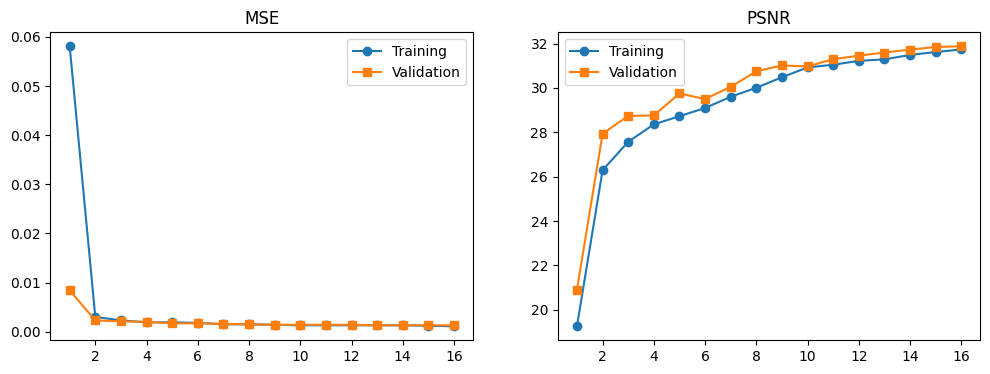

In [14]:
#Learning curves :

losses = [0.0581,0.0030,0.0023,0.0019,0.0019,0.0018,0.0015,0.0015,0.0014,0.0013,0.0013,0.0013,0.0013,0.0013,0.0012,0.0011]
psnr_metrics = [19.2606,26.2923,27.5734,28.3589,28.7254,29.0963,29.6027,30.0083,30.4794,30.9247,31.0449,31.2209,31.2880,31.4872,31.6188,31.7334]

val_losses = [0.0084,0.0023,0.0021,0.0020,0.0017,0.0017,0.0016,0.0015,0.0014,0.0014,0.0014,0.0014,0.0013,0.0013,0.0013,0.0013]
val_psnr = [20.9083,27.9360,28.7413,28.7584,29.7518,29.4989,30.0495,30.7499,31.0135,30.9693,31.2950,31.4534,31.5954,31.7275,31.8442,31.8773]

epoch = np.arange(1, 17)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epoch, losses, label = 'Training', marker='o')
plt.plot(epoch, val_losses, label = 'Validation', marker='s')
plt.legend()
plt.title('MSE')

plt.subplot(1, 2, 2)
plt.plot(epoch, psnr_metrics, label = 'Training',  marker='o')
plt.plot(epoch, val_psnr, label = 'Validation',  marker='s')
plt.legend()
plt.title('PSNR')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Our U-Net3+ model successfully upscaled images from (128×128) to (512×512) with high PSNR scores, demonstrating its effectiveness for super-resolution in grayscale medical imaging.


**Results**:

*   val_loss: 0.0013 (mse)
*   val_psnr_metric: 31.8773



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


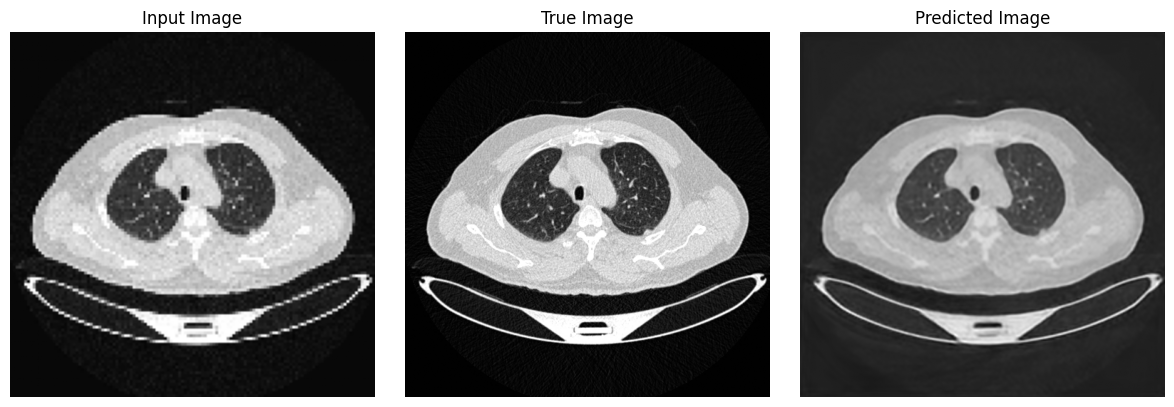

In [38]:
index = np.random.randint(X_train.shape[0])

input_image = X_train[index]
true_image = y_train[index]
predicted_image = model.predict(tf.expand_dims(input_image, axis=0))[0]

plt.figure(figsize=(12, 4))


plt.subplot(1, 3, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')


plt.subplot(1, 3, 2)
plt.imshow(true_image, cmap='gray')
plt.title('True Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(predicted_image, cmap='gray')
plt.title('Predicted Image')
plt.axis('off')

plt.tight_layout()
plt.show()